<h1>Table of Contents<span class="tocSkip"></span></h1>

[1. Introduction](#Introduction)

1  Introduction
1.1  Data source
1.2  Stakeholders
1.3  Water Quality
2  EDA (Exploratory Data Analysis)
2.1  Objectives
2.2  Load Data
2.2.1  Missing Values By Column
2.2.2  Numeric Data
2.2.2.1  Distributions
2.2.2.2  Classification: measured versus expected
2.2.2.3  Statistical summary and boxplots grouped by potability
2.2.3  Considerations
2.3  Principle components analysis (PCA)
2.3.1  Scale the data
2.3.1.1  Verifying the scaling
2.3.2  Calculate the PCA transformation
2.4  Numeric Data
2.4.1  Parameters correlation heatmap
2.4.1.1  Scatterplots of numeric features against Potability
2.5  Summary
3  Modeling
3.1  Data treatment
3.1.1  Missing values
3.1.2  Imputing missing parameter (predictor) values
3.1.3  Scale the data
3.1.4  Train/Test Split
3.2  Classification models
3.2.1  Declaration
3.2.2  Parameters
3.2.3  Grid of models
3.2.4  Training
3.2.5  Models performance
3.2.6  Best model
4  Conclusions
[2. EDA](#EDA (Exploratory Data Analysis))

[3. Modeling](#Modeling))

[4. Conclusions](#Conclusion)

In [1]:
# Default libraries: pandas, numpy
# import beakerx
import cProfile
import datetime
import math
import os
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import urbangrammar_graphics as ugg

from IPython.display import Markdown as md
from collections import Counter
from clustergram import Clustergram
from datetime import datetime

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, BaggingClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, GridSearchCV, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

pd.options.display.float_format = "{:.2f}".format

# Introduction<a id='1'></a>

Drinking water is something essential for life and should be available for everyone. But, unfortunately, this is not true for everyone around the world. There are places where there is no water availability, and then people usually avoid to live on these places. However, there are locations where the water is accessible, but it is not safe for human use due to all sorts of contaminants.

This project will address if the water is potable for 3276 different water bodies evaluating the water physical properties and classifying them as potable or non-potable.

## Data source<a id='1.1'></a>

This data is available on Kaggle, a public data repository, and can be found at https://www.kaggle.com/adityakadiwal/water-potability/activity.

There is no information if this is real data or not. If it is real there is nothing about the geographical location of these water bodies.

## Stakeholders<a id='1.2'></a>

The solution of this problem is subject of interest for:
 - **Governmental or Non-governmental entities** worried about the population public policies of health and sanitation
 - **Water treatment companies** that could provide their services on the location of these water bodies and need to know which kind of facilities they would have to use accordingly to the water treatment required
 - **Researchers** looking for answers about the water usage versus health indicators in a given location, or the waste disposition along the water body and its treatment, and other water consumption related topics

## Water Quality<a id='1.3'></a>

We will evaluate the following water physical attributes:

**1. pH value:**
indicates if the water is acidic or alkaline condition. WHO has recommended the maximum permissible limit of pH from 6.5 to 8.5.

**2. Hardness:**
is the concentration of calcium and magnesium salts.

**3. Solids (Total dissolved solids - TDS):**
inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates, etc. The desirable limit is 500 mg/l, and the maximum limit is 1000 mg/l.

**4. Chloramines:**
are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.

**5. Sulfate:**
Sulfates are naturally occurring substances in minerals, soil, and rocks. The principal commercial use of sulfate is in the chemical industry. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although some geographic locations present much higher concentrations (1000 mg/L).

**6. Conductivity:**
electrical conductivity (EC) measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceed 400 μS/cm.

**7. Organic_carbon:**
Total Organic Carbon (TOC) measures the total amount of carbon in organic compounds in pure water. According to US EPA, < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water used for treatment.

**8. Trihalomethanes:**
THMs are chemicals found in water treated with chlorine. The concentration of THMs in drinking water varies with the level of organic material, the amount of chlorine used in the treatment, and the temperature when it was treated. THM levels up to 80 ppm are considered safe in drinking water.

**9. Turbidity:**
is a measure of light-emitting properties of water, and the test is used to indicate the waste discharge concerning the colloidal matter. WHO recommends turbidity below 5.00 NTU.

**10. Potability:**
is our target variable indicating if water is safe for human consumption (potable) or not (non-potable):

    - 1: potable
    - 0: non-potable.

In [2]:
dict_range = {
    'ph': [6.5, 8.5],
    'Hardness': [120, 170],
    'Solids': [500, 1000],
    'Chloramines': [0, 4],
    'Sulfate': [3, 30],
    'Conductivity': [0, 400],
    'Organic_carbon': [0, 4],
    'Trihalomethanes': [0, 80],
    'Turbidity': [0, 5]
}

dict_labels = {
    'ph': [[-np.inf, -10e-5, 6.5, 8.5, 14, np.inf],
           ['out_range_below', 'below', 'potable', 'above', 'out_range_high']],
    'Hardness': [[-np.inf, -10e-5, 120, 170, np.inf],
                 ['out_range_below', 'below', 'potable', 'above']],
    'Solids': [[-np.inf, -10e-5, 500, 1000, np.inf],
               ['out_range_below', 'below', 'potable', 'above']],
    'Chloramines': [[-np.inf, -10e-5, 4, np.inf],
                    ['out_range_below', 'potable', 'above']],
    'Sulfate': [[-np.inf, -10e-5, 3, 30, np.inf],
                ['out_range_below', 'below', 'potable', 'above']],
    'Conductivity': [[-np.inf, -10e-5, 400, np.inf],
                     ['out_range_below', 'potable', 'above']],
    'Organic_carbon': [[-np.inf, -10e-5, 2, 4, np.inf],
                       ['out_range_below', 'potable', 'to be treated', 'above']],
    'Trihalomethanes': [[-np.inf, -10e-5, 80, np.inf],
                        ['out_range_below', 'potable', 'above']],
    'Turbidity': [[-np.inf, -10e-5, 5, np.inf],
                  ['out_range_below', 'potable', 'above']]
}

# EDA (Exploratory Data Analysis)<a id='2'></a>

This section is dedicated to:
- data collection
- organization and cleaning
- assuring data adequacy for the modelling process

## Objectives<a id='2.1'></a>

Check data integrity for a classification task:
- Define the target variable.
- Evaluate if the parameters are helpful as discriminators for the classification.
- Is there any issue with the data?

## Load Data<a id='2.2'></a>

In [3]:
path = os.getcwd() + '\\Water_potability\\'

water = pd.read_csv(path + 'water_potability.csv',
                    index_col=None,
                    delimiter=',')
type(water)
water.info()
water.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,0
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,0
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,0
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,0
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,0


- 3276 entries
- Target: `Potability` indicates if the water is safe for human consumption:
    - 1: potable
    - 0: non-potable
- Remaining columns are the parameters to be used to classify the entry as potable or not.
- Numerical features:
    - float64(9) - parameters
    - int64(1) - target
- Categorical:
    - none
- Headers: names are meaningful and related to the problem.
- Missing values: present - further investigation required.

### Missing Values By Column<a id='2.2.1'></a>

Counting the number of missing values in each column and sorting them.

In [4]:
#Count (using `.sum()`) the number of missing values (`.isnull()`) in each column of data
#as well as the percentages (using `.mean()` instead of `.sum()`).
#Order them (increasing or decreasing) using sort_values
missing = pd.concat([water.isnull().sum(), 100 * water.isnull().mean()],
                    axis=1)
missing.columns = ['count', '%']
missing = missing[missing['count'] > 0]
missing.sort_values(by='%', ascending=False)

,count,%
Sulfate,781,23.84
ph,491,14.99
Trihalomethanes,162,4.95


- **Columns with missing data**: 3
- **Most missing**: `Sufalte` - 23.8%
- **Target missing**: none

### Numeric Data<a id='2.2.2'></a>

#### Distributions<a id='2.2.2.1'></a>

For this problem we have the potable range for each parameter. Let evaluate the parameter distribution against the potable range and also some common knowledge about drinking water.

The following histograms will showcase:
- histogram of all data for each parameter (blue)
- distribution of the parameter for the potable (dark green) and non-potable (green) water
- hatched area shows what is considered potable for that parameter

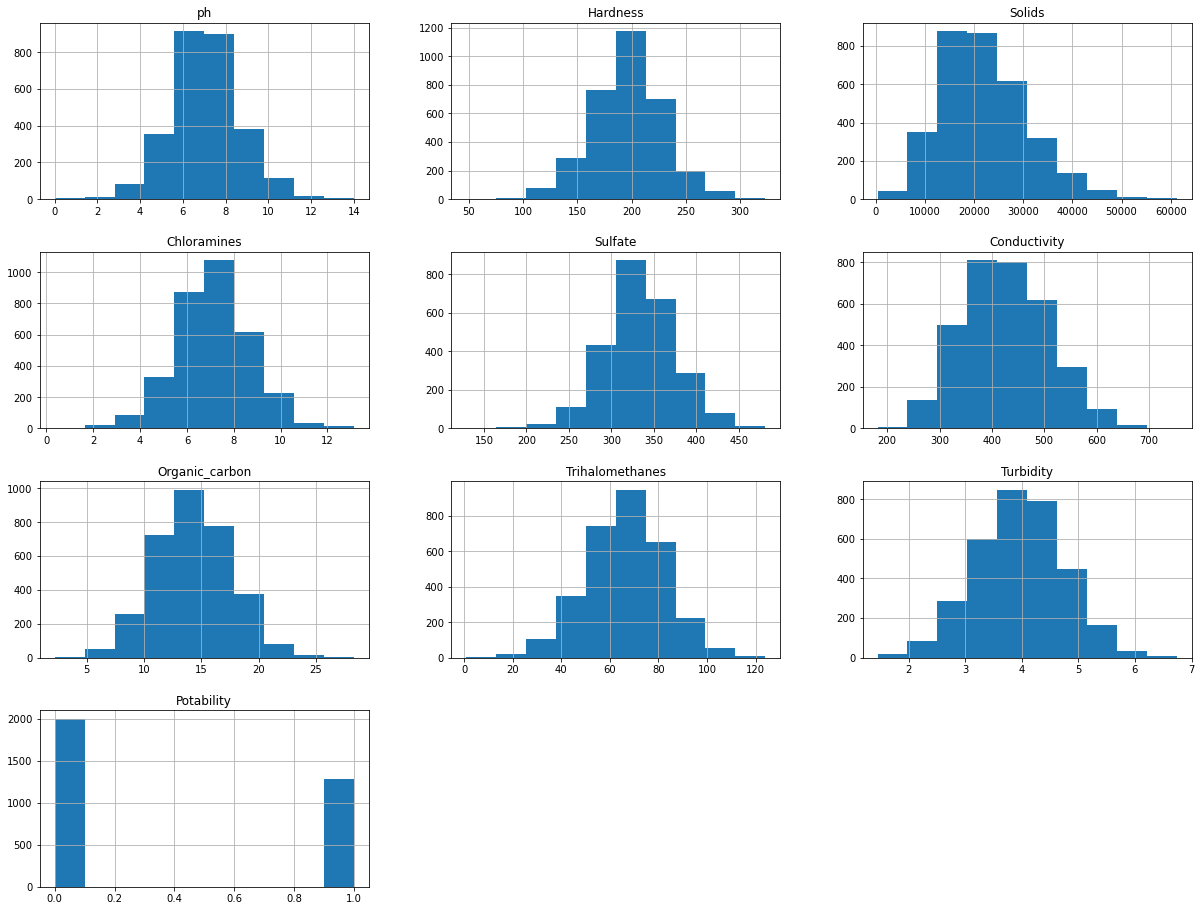

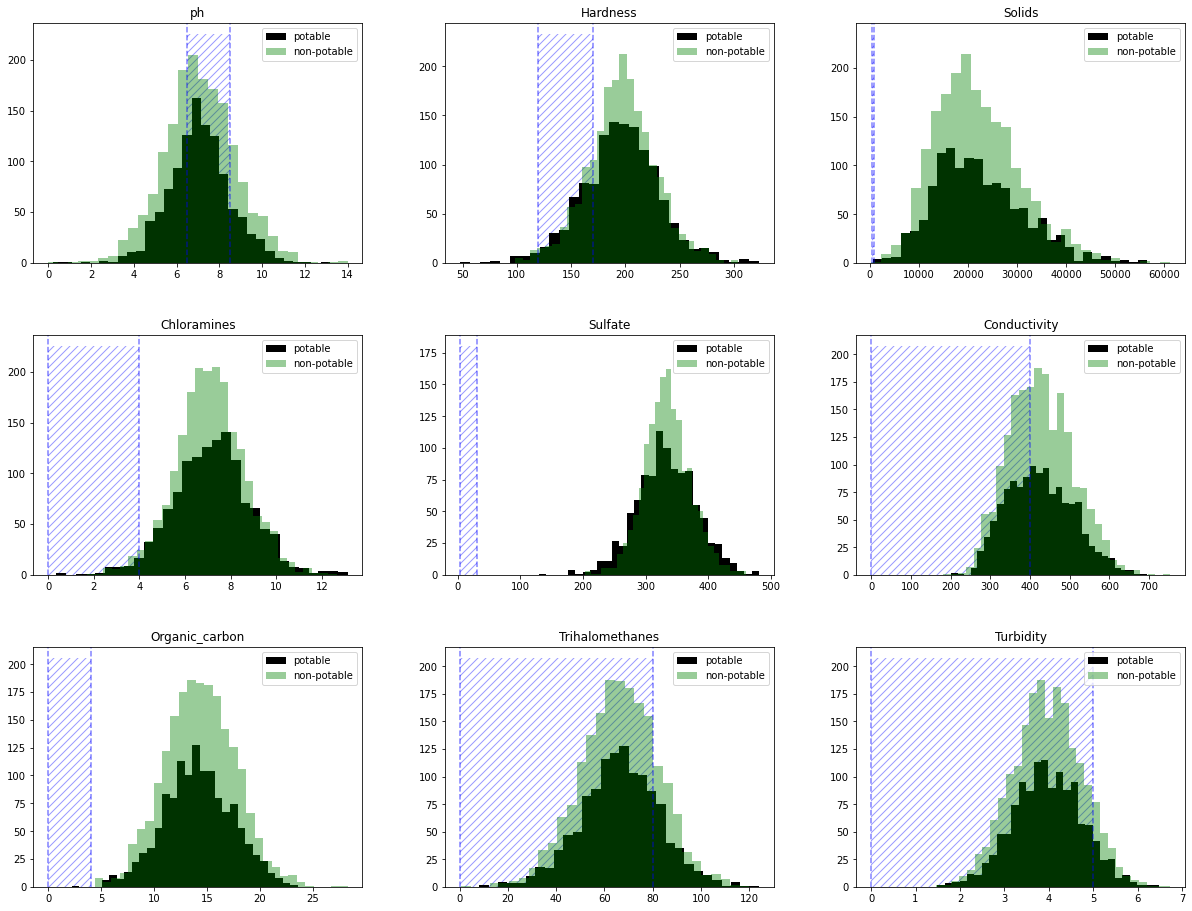

In [5]:
def visualize_all(df, b, r):
    fig = plt.figure(figsize=(20, 15))
    rows = math.ceil(math.sqrt(len(water.keys()) - 1))
    cols = math.floor(math.sqrt(len(water.keys()) - 1))

    ax_array = fig.subplots(rows, cols)

    i = 0
    for param in water.keys():
        if param != 'Potability':
            i = i + 1
            potable = df[df['Potability'] == 1][param]
            no_potable = df[df['Potability'] == 0][param]

            ax = ax_array[math.ceil(i / cols) - 1, ((i - 1) % cols)]
            ax.title.set_text(param)
            ax.axvline(x=r[param][0], c='b', ls='--', alpha=.5)
            ax.axvline(x=r[param][1], c='b', ls='--', alpha=.5)
            ax.hist(potable, bins=b, color='black', alpha=1, label='potable')
            ax.hist(no_potable,
                    bins=b,
                    color='green',
                    alpha=0.4,
                    label='non-potable')
            ax.legend()
            y_bottom, y_top = ax.get_ylim()
            ax.fill_betweenx([0, y_top + 10],
                             r[param][0],
                             r[param][1],
                             hatch="///",
                             facecolor="none",
                             edgecolor="b",
                             linewidth=0.01,
                             alpha=.4)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.25,
                        hspace=0.3)
    plt.show()

# Histograms of all numeric features
water.hist(figsize=(20, 15))
plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.25,
                        hspace=0.3);

visualize_all(water, 30, dict_range)

- **Distribution**: All parameters have a distribution close to the normal distribution
- **Outliers**: there are no obvious outliers in the distributions
- **Constant values**: none

Once all parameters have a mean and distribution quite similar for the potable and non-potable categories and we have some missing values in the data, we could think that the the whole entry with some missing value would be bad data.

To check this hypothesis we can analyze the distribution of the data without the missing values below.

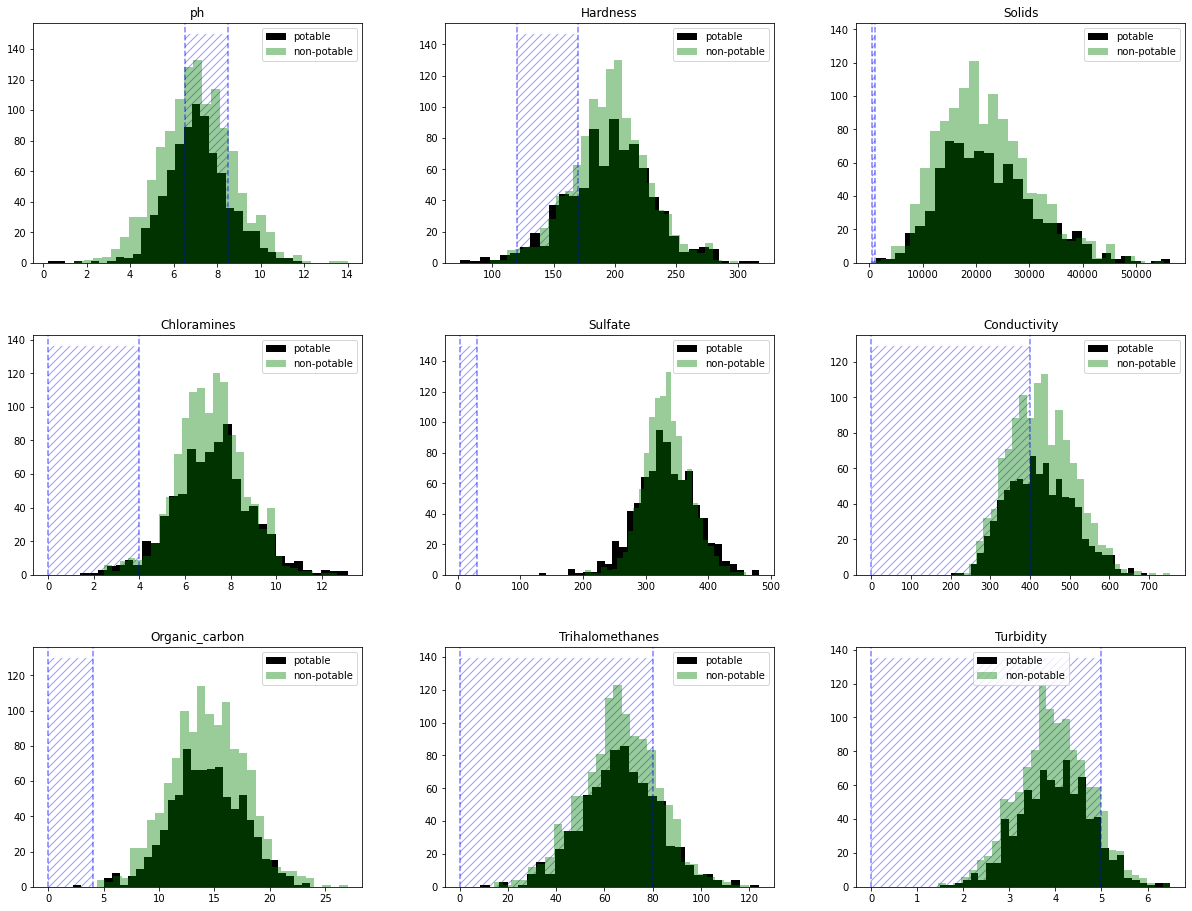

In [6]:
visualize_all(water.dropna(), 30, dict_range)

- The data without the missing values does not showcase any improvement on the parameters' discrimination capability.
- Rows with missing were not the root of the problem with the overlapping distributions.
- By the WHO, pH < 6.5 is not considered as potable water, however we have 258 rows classified as potable with pH < 6.5. For example, the pH of gastric acid is 1.5 to 3.5 and in the data we have a pH 0.22 classified as potable. Something is wrong.
- `Solids`, `Sulfates`, and `Organic Carbon` distributions are completely out of what is considered potable.

#### Classification: measured *versus* expected<a id='2.2.2.2'></a>

Following we have each parameter labeled as **expected**, classification measured matches the classification of the parameter following the potable range, or **non-expected** otherwise.

The columns in each bar plot represent the measured classification non-potable and potable. Colors: dark green is non-expected and lighter green expected.

In [7]:
def label_param(df, param, group_by_param, label_values, label_names):
    df = df[[param, group_by_param]]
    df = df.dropna()
    df[param + '_cat'] = pd.cut(df[param],
                                bins=label_values,
                                labels=label_names)
    clfd = df
    conditions = [
        (clfd[group_by_param] == 1) & (clfd[param + '_cat'] == 'potable'),
        (clfd[group_by_param] == 0) & (clfd[param + '_cat'] != 'potable'),
        (clfd[group_by_param] == 1) & (clfd[param + '_cat'] != 'potable'),
        (clfd[group_by_param] == 0) & (clfd[param + '_cat'] == 'potable'),
    ]
#     print(conditions)
    choices = ['expected', 'expected', 'non-expected', 'non-expected']
    clfd['classification'] = np.select(conditions, choices, default='NaN')
#     print(clfd)
    ranges = clfd.drop(columns=[param + '_cat'])
    
    ranges = ranges.groupby([group_by_param, 'classification']).agg(['count'])
    ranges = ranges[param].reset_index()
    ranges = ranges.pivot(index='classification', columns=group_by_param, values='count')

    return ranges
# , clfd

# param = 'Solids'
# group_by_param = 'Potability'
# data, raw= label_param(water,param,group_by_param,dict_labels[param][0],dict_labels[param][1])
# print(data)
# raw.groupby(['Potability','Solids_cat']).count()

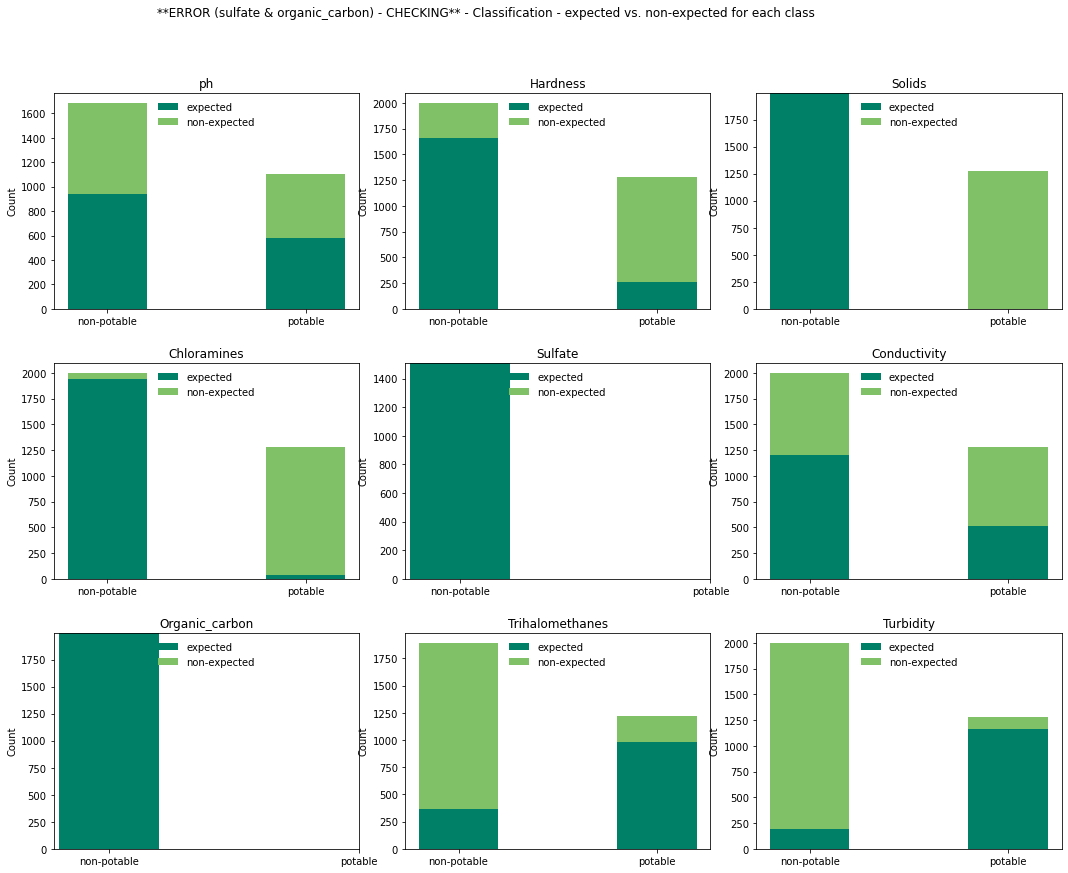

In [8]:
def visualize_all_labeled(df, group_by_param):
    rows = math.ceil(math.sqrt(len(df.keys()) - 1))
    cols = math.floor(math.sqrt(len(df.keys()) - 1))

    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(20, 15))
    fig.suptitle('**ERROR (sulfate & organic_carbon) - CHECKING** - Classification - expected vs. non-expected for each class')
    
    i = 0
    for param in water.keys():
        if param != 'Potability':
            i = i + 1
            
            r = int((i - 1) / cols)
            c = i - r * cols - 1
            
            ax = axes[math.ceil(i / cols) - 1, ((i - 1) % cols)]
            ax.title.set_text(param)
        
            data = label_param(water,param,group_by_param,dict_labels[param][0],dict_labels[param][1])
            columns = list(data.keys())
#             print(param)
#             print(data)

            # Get some pastel shades for the colors
            n_entries = len(data)
            colors = plt.cm.summer(np.linspace(0, 0.5, len(data)))

            index = np.arange(len(columns)) + 0.3
            bar_width = 0.4

            # Initialize the vertical-offset for the stacked bar chart.
            y_offset = np.zeros(len(columns))

            # Plot bars and create text labels for the table
            cell_text = []
            for e in range(n_entries):
                x = list(data.keys())
                y = list(data.iloc[e])
                ax.bar(x,
                        y,
                        bar_width,
                        bottom=y_offset,
                        color=colors[e])
                y_offset = y_offset + y
                cell_text.append(['%1.0f' % (x) for x in y])

            # Reverse colors and text labels to display the last value at the top.
            # colors = colors[::-1]
            # cell_text.reverse()

            # Add a table at the bottom of the axes
#             the_table = ax.table(cellText=cell_text,
#                                   rowLabels=list(data.index),
#                                   rowColours=colors,
#                                   colLabels=['non-potable','potable'],
#                                   loc='bottom')

            ax.set_ylabel('Count')
            ax.set_xticks(list(data.keys()))
            ax.set_xticklabels(['non-potable','potable'])
            axes[r,c].legend(['expected','non-expected'],loc='upper center', frameon=False)
#             axes[r,c].legend(loc='upper center', frameon=False, ncol=2)
#             plt.legend(list(data.keys()))
#             axes[r,c].legend(, title=data.keys(), frameon=False, ncol=2)
            plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.15,
                        hspace=0.25)
    
    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.show()

visualize_all_labeled(water, 'Potability')

Values classified as potable in the non-potable bar and vice-versa could be considered errors.
- **Classification correctness:** majority of the the classification measured is not agreeing to the expected classification taking WHO standards into consideration for all parameters.

- **Trend:** the misclassification of potable and non-potable water is common for all parameter with no  preference for any class.

    - `Chloramines`, the amount of Chlorine in the water, suggests that the data is composed of water heavily treated, once the distribution shows a larger occurrence of values above what is considered potable. We can imagine that, even after an intense treatment, they were classified as potable because there were no other water source available, and the WHO criterias were not considered. If data came from somewhere were WHO standards are strictly followed, then we could confirm a big issue with the classification data.

Once we have so many errors in classification and we do not have further information about the data source we can imagine a different scenario. The data came from locations without another source of water and it was classified as potable simply considering if they were consumed by the population or not.

#### Statistical summary and boxplots grouped by potability<a id='2.2.2.3'></a>

Let's visualize each parameter split into potable and non-potable in a box-plot and evaluate the summary of their statistical metrics.

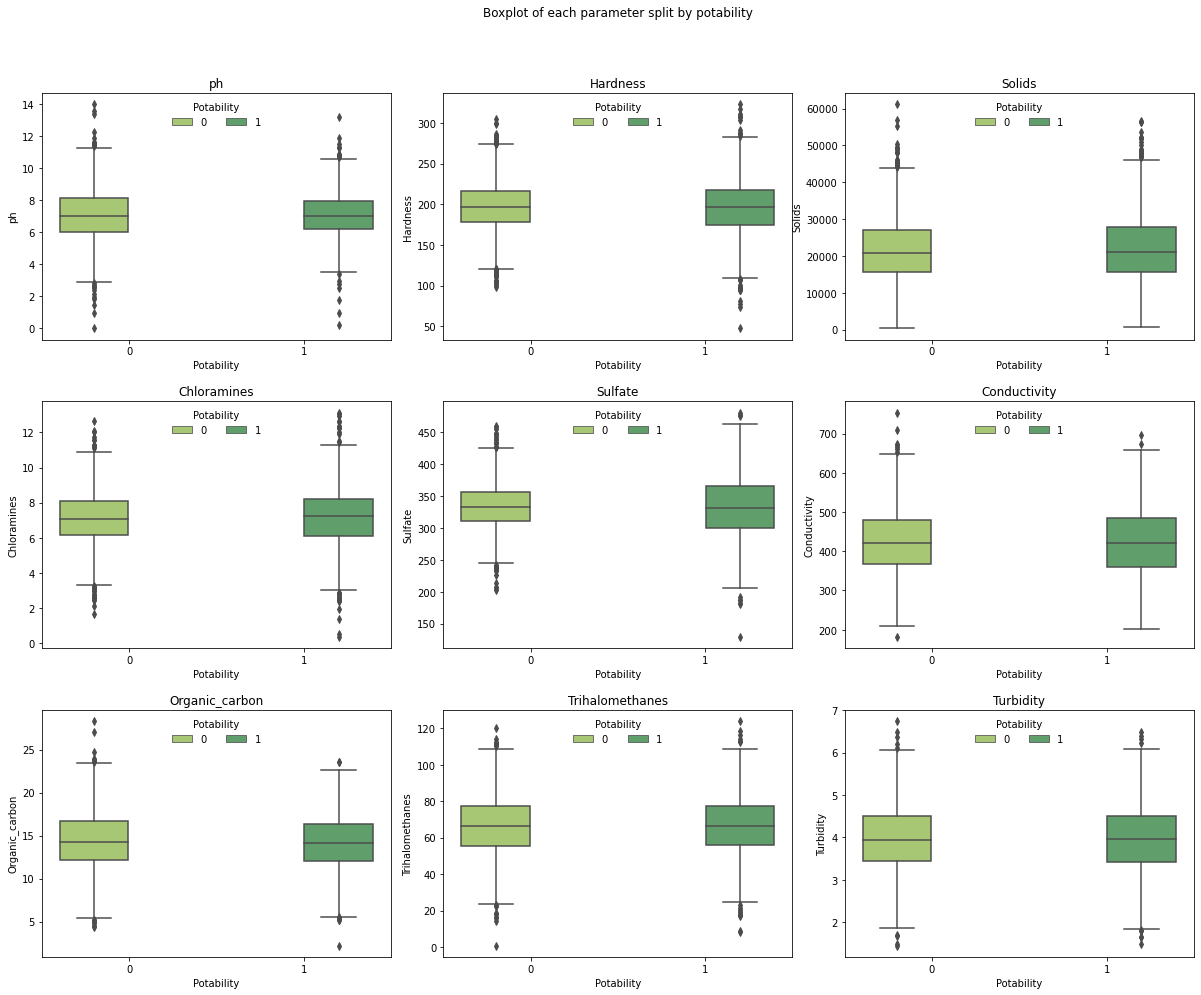

,count,mean,std,min,25%,50%,75%,max
ph,2785.00,7.08,1.59,0.00,6.09,7.04,8.06,14.00
Hardness,3276.00,196.37,32.88,47.43,176.85,196.97,216.67,323.12
Solids,3276.00,22014.09,8768.57,320.94,15666.69,20927.83,27332.76,61227.20
Chloramines,3276.00,7.12,1.58,0.35,6.13,7.13,8.11,13.13
Sulfate,2495.00,333.78,41.42,129.00,307.70,333.07,359.95,481.03
Conductivity,3276.00,426.21,80.82,181.48,365.73,421.88,481.79,753.34
Organic_carbon,3276.00,14.28,3.31,2.20,12.07,14.22,16.56,28.30
Trihalomethanes,3114.00,66.40,16.18,0.74,55.84,66.62,77.34,124.00
Turbidity,3276.00,3.97,0.78,1.45,3.44,3.96,4.50,6.74
Potability,3276.00,0.39,0.49,0.00,0.00,0.00,1.00,1.00


In [9]:
def visualize_all_box(df, group):
    rows = math.ceil(math.sqrt(len(df.keys()) - 1))
    cols = math.floor(math.sqrt(len(df.keys()) - 1))

    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(20, 15))
    fig.suptitle('Boxplot of each parameter split by potability')

    i = 0
    for param in water.keys():
        if param != 'Potability':
            i = i + 1

            r = int((i - 1) / cols)
            c = i - r * cols - 1
            sns.boxplot(ax=axes[r, c],
                        data=df,
                        x=group,
                        y=param,
                        hue=group,
                        palette='summer_r'                                                
                       ).set_title(param)
            axes[r,c].legend(loc='upper center', title=group, frameon=False, ncol=2)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.15,
                        hspace=0.25)
    plt.show()

visualize_all_box(water, 'Potability')

# Statistical summary of the numerical columns
summ = water.describe().transpose()
summ

Boxplots:
- **Median:** values for potable and non-potable are very similar for all the parameters.
- **Quartiles:** have the same range for both classes.
- **Max/Min**: no significant differences between the classes.
- **Outliers**: there are outliers but they are not so numerous.

Statistical summary:
- **Mean x median**: metrics have close values (expected for normal distributions)
- **Skew (symmetry)**: 25% and 75% are consistently almost symmetrical to the median (expected for normal distributions)
- **Range**: no negative values (in accordance to the parameter definitions). The range among all parameters is wide.
- **Anomalies** (e.g., outside the range such as -1 and 999): absent

*Mean and standard deviation with close values for both classes indicates a poor discriminator in the classification task.*

### Considerations<a id='2.2.3'></a>

Data is showing to be a unreliable source of information for the classification of the water as potable or non-potable:
- **Statistical significance**
    - The average, shape and spread of the distribution of all parameters for potable and non-potable water overlaps. It indicates that statistical analysis won't be effective due to a poor statistical significance.
- **Wrong classification**
    - For all the parameters, a considerable amount of data is being classified as potable being outside the presumed potable range. The opposite also is true, a lot of entries are classified as non-potable while belonging to the presumed potable range.

 
Although the exploratory data analysis suggests that the classification is wrong, we will consider it as correct once we don't have further information about the origin of the data. However, we are no expecting a good performance of the models once the data for potable and non-potalbe are quite similar and not the best for the modelling.

## Principle components analysis [(PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)<a id='2.3'></a>

The basic steps in this process are:

1. scale the data
 fit the PCA transformation
3. apply the transformation to the data to create the derived features
4. (optionally) use the derived features to look for patterns in the data and explore the coefficients

### Scale the data

In [10]:
water_summary = water.groupby('ph').agg(
    #     count=pd.NamedAgg(column='Hardness', aggfunc='size'), #could pick any column here
    Hardness=pd.NamedAgg(column='Hardness', aggfunc='sum'),
    Solids=pd.NamedAgg(column='Solids', aggfunc='sum'),
    Chloramines=pd.NamedAgg(column='Chloramines', aggfunc='sum'),
    Sulfate=pd.NamedAgg(column='Sulfate', aggfunc='sum'),
    Conductivity=pd.NamedAgg(column='Conductivity', aggfunc='sum'),
    Organic_carbon=pd.NamedAgg(column='Organic_carbon', aggfunc='sum'),
    Trihalomethanes=pd.NamedAgg(column='Trihalomethanes', aggfunc='sum'),
    Turbidity=pd.NamedAgg(column='Turbidity', aggfunc='sum'),
    # Potability=pd.NamedAgg(column='Potability', aggfunc='sum'),
).reset_index()
# water_summary.head()

#New dataframe, `db_summary_scale` from `db_summary` whilst setting the index to the selected criteria
df_summary_scale = water_summary.set_index('ph', drop=True)
water_summary = water_summary.set_index('ph', drop=True)
#Save the index's labels (using the index attribute of `db_summary_scale`) into the variable 'db_summary_index'
df_summary_index = df_summary_scale.index
#Save the column names (using the `columns` attribute) of `db_summary_scale` into the variable 'db_summary_columns'
df_summary_columns = df_summary_scale.columns
# df_summary_scale.head()
df_summary_scale.dtypes

Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
dtype: object

- Columns are all numeric

In [11]:
# Scale data
df_summary_scale = scale(df_summary_scale)

#Create a new dataframe from `db_summary_scale` using the column names `db_summary_columns`
df_summary_scaled_df = pd.DataFrame(df_summary_scale,
                                    columns=df_summary_columns)
# df_summary_scaled_df.head()

#### Verifying the scaling

Validating the scaling:
- Check the average, standard deviation, and unbiased standard deviation estimator (ddof = 1)

In [12]:
#Call `db_summary_scaled_df`'s `mean()` method
validate = df_summary_scaled_df.agg(['mean', 'std']).T
validate['ddof_1'] = df_summary_scaled_df.std(ddof=0)
validate

,mean,std,ddof_1
Hardness,0.00,1.00,1.00
Solids,0.00,1.00,1.00
Chloramines,-0.00,1.00,1.00
Sulfate,0.00,1.00,1.00
Conductivity,-0.00,1.00,1.00
Organic_carbon,-0.00,1.00,1.00
Trihalomethanes,0.00,1.00,1.00
Turbidity,-0.00,1.00,1.00


- average is zero
- all variables with the same standard deviation
- STD(ddof) = 1 as expected in a scaling

### Calculate the PCA transformation

Fit the PCA transformation using the scaled data.

In [13]:
df_pca = PCA().fit(df_summary_scale)

Plot the cumulative variance ratio with number of components.

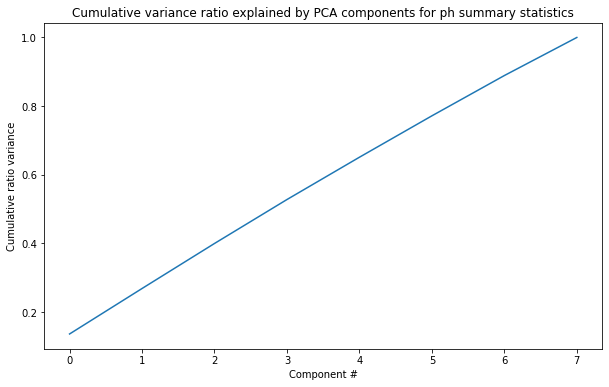

In [14]:
#Call the `cumsum()` method on the 'explained_variance_ratio_' attribute of `db_pca` and
#create a line plot to visualize the cumulative explained variance ratio with number of components
#Set the xlabel to 'Component #', the ylabel to 'Cumulative ratio variance', and the
#title to 'Cumulative variance ratio explained by PCA components for state/resort summary statistics'
#Hint: remember the handy ';' at the end of the last plot call to suppress that untidy output
plt.subplots(figsize=(10, 6))
plt.plot(df_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for ph summary statistics');

- There are no relevant components to explain the variance of the data.

In [15]:
#Call `db_pca`'s `transform()` method, passing in `db_summary_scale` as its argument
df_pca_x = df_pca.transform(df_summary_scale)
# df_pca_x.shape

Plot the first two derived features (the first two principle components) and label each point.

In [16]:
# x = df_pca_x[:, 0]
# y = df_pca_x[:, 1]
# df_index = df_summary_index
# pc_var = 100 * df_pca.explained_variance_ratio_.cumsum()[1]
# plt.subplots(figsize=(10,8))
# plt.scatter(x=x, y=y)
# plt.xlabel('First component')
# plt.ylabel('Second component')
# plt.title(f'Water potability summary PCA, {pc_var:.1f}% variance explained')
# for s, x, y in zip(water, x, y):
#     plt.annotate(s, (x, y))

In [17]:
#Create a dataframe containing the values of the first two PCA components
#Remember the first component was given by db_pca_x[:, 0],
#and the second by db_pca_x[:, 1]
#Call these 'PC1' and 'PC2', respectively and set the dataframe index to `db_summary_index`
pca_df = pd.DataFrame({
    'PC1': df_pca_x[:, 0],
    'PC2': df_pca_x[:, 1]
},
                      index=df_summary_index)
# pca_df.head()

Concatenating both parts on axis 1 and using the indexes.

In [18]:
water_avg_potability = water.groupby('ph')['Potability'].mean()
# water_avg_potability.sort_values(ascending=False).head()

In [19]:
#Use pd.concat to concatenate `pca_df` and `db_avg` along axis 1
# remember, pd.concat will align on index
pca_df = pd.concat([pca_df, water_avg_potability], axis=1)
pca_df.head()

,PC1,PC2,Potability
ph,,,
0.00,2.69,-2.45,0
0.23,2.68,0.20,1
0.98,0.60,3.08,0
0.99,-0.51,-2.03,1
1.43,-0.08,-0.16,0


In [20]:
# pca_df.dtypes

Checking for missing values

In [21]:
pca_df[pca_df.isnull().any(axis=1)]

,PC1,PC2,Potability
ph,,,


- No missing values

Text(0.5, 1.0, 'Ski states summary PCA, 26.9% variance explained')

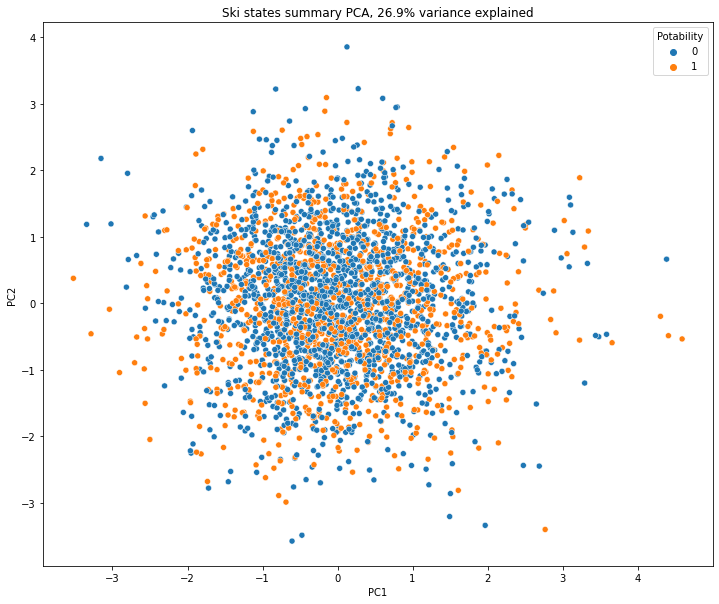

In [22]:
# Create a seaborn scatterplot by calling `sns.scatterplot`
# Specify the dataframe pca_df as the source of the data,
# specify 'PC1' for x and 'PC2' for y,
# specify 'target' for the pointsize (scatterplot's `size` argument),
# specify 'catergories' foar `hue`
# specify sorter for `hue_order`
x = pca_df.PC1
y = pca_df.PC2
ph = pca_df.index
plt.subplots(figsize=(12, 10))
# Note the argument below to make sure we get the colours in the ascending
# order we intuitively expect!
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Potability',
    data=pca_df,
    hue_order=pca_df.Potability.sort_values(ascending=True).unique())
# sns.scatterplot(x='PC1', y='PC2', size='Potability', hue='Quartile',
#                 hue_order=pca_df.Quartile.cat.categories, data=pca_df)
#if the amount of data allows, annotate with the labels
# for s, x, y in zip(ph, x, y):
#     plt.annotate(s, (x, y))
pc_var = 100 * df_pca.explained_variance_ratio_.cumsum()[1]
plt.title(f'Ski states summary PCA, {pc_var:.1f}% variance explained')

- No clustering by PCA and potability.

In [23]:
pd.DataFrame(df_pca.components_, columns=df_summary_columns)

,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,-0.18,0.69,-0.53,-0.15,0.21,-0.04,-0.27,0.28
1,0.46,-0.06,-0.39,0.14,-0.12,0.61,-0.31,-0.37
2,0.51,-0.06,-0.11,-0.72,0.30,-0.13,0.29,-0.06
3,0.40,-0.05,0.05,-0.12,-0.58,-0.36,-0.45,0.38
4,-0.15,0.33,-0.14,-0.14,-0.56,-0.26,0.26,-0.62
5,-0.20,0.14,0.54,-0.40,0.14,0.12,-0.58,-0.34
6,0.06,-0.26,-0.27,0.27,0.38,-0.62,-0.33,-0.38
7,0.52,0.57,0.42,0.41,0.18,-0.10,0.13,-0.07


- No remarkable values could be found in the components of the PCA.

## Numeric Data<a id='2.4'></a>

Evaluating the numeric data correlations and distributions.

### Parameters correlation heatmap<a id='2.4.1'></a>

A great way to gain a high level view of relationships amongst the parameters.

<AxesSubplot:>

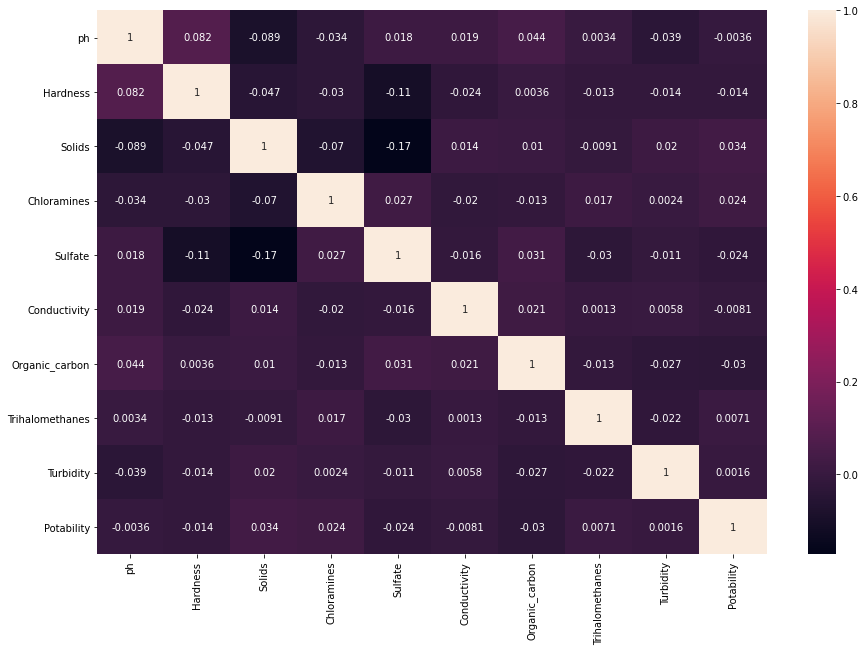

In [24]:
#Show a seaborn heatmap of correlations in data
plt.subplots(figsize=(15, 10))
sns.heatmap(water.corr(), annot=True)

- We could correlate `Turbidity` with `Solids` and `Organic_carbon`, but they do not have a higher correlation in the data.
- No strong correlations were found in the data set.

#### Scatterplots of numeric features against Potability

In [25]:
# define useful function to create scatterplots of ticket prices against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x=col, y='Potability', data=water, alpha=0.5)
        ax.set(xlabel=col, ylabel='Potability')
    nsubplots = nrow * ncol
    for empty in range(i + 1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [26]:
#Use a list comprehension to build a list of features from the columns of `ski_data` that
#are _not_ any of 'Name', 'Region', 'state', or 'AdultWeekend'
# features = [f for f in water.columns if f not in ['Name', 'Region', 'state', 'AdultWeekend']]
features = [f for f in water.columns if f not in ['Potability']]

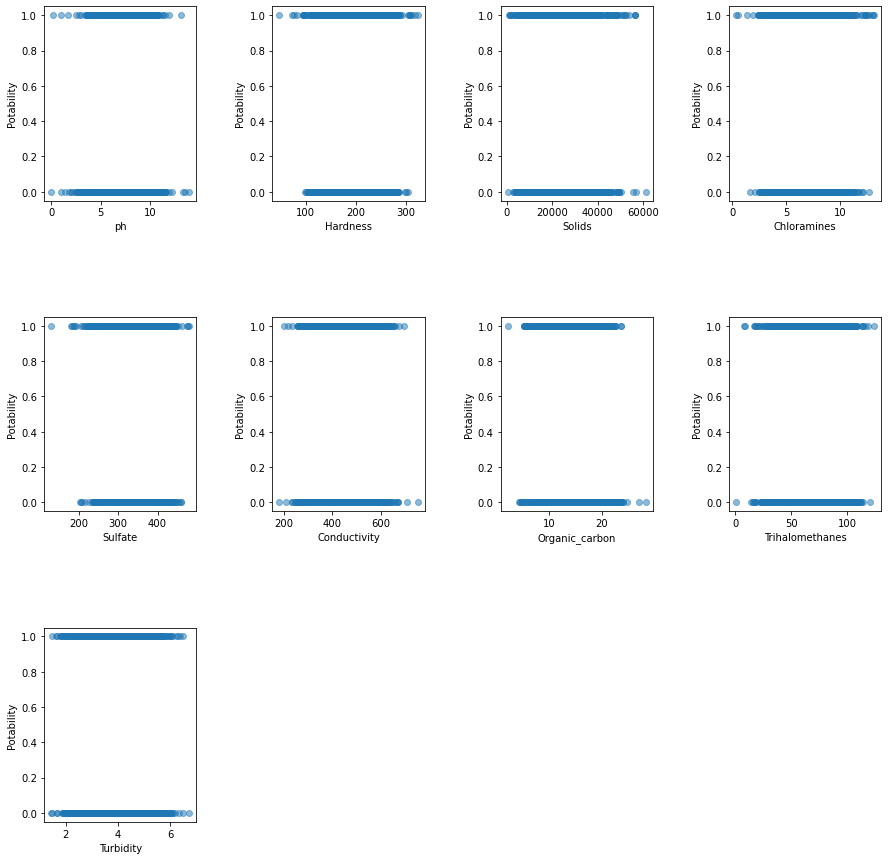

In [27]:
scatterplots(features, ncol=4, figsize=(15, 15))

- The scatterplots don't show any significant split in the data.

## Summary

So far, we couldn't find classifiers to define the water as potable.

- Numerical: 10

- Categorical: 0

Data seems to be incorrect both for the classification and the distribution for each category. We will carry on the analysis once we don't have more details about the data source. We cannot be sure if the data is wrong or if this a really poor  situation for the consumers of this water.

# Modeling

During the data assessment we did not remove any column or adjusted any entries. But we have missing values that must be treated.

## Data treatment

This step will deal with the missing values and splitting the data into training and test sets.

### Missing values

Once we have a decent amount of data when we remove all the rows containing at least one missing value there is no need to impute the mean or median values into the missing values.

<font size="5"> **Questions:** </font> 

When is reasonable to fill the data with mean/median and why there is a lot of notebooks on Kaggle talking about imbalanced data?

Which criteria should I adopt to drop missing or fill them? I considered that we have enough data to run the models if we remove the missing values so I skipped the imputing steps.

If I had to fill out the data is there any criteria to choose the mean or the median? Skewed distribution: median, otherwise: mean?

In [28]:
water = water.dropna()

### Imputing missing parameter (predictor) values

The mean and median of the parameters are really close what demonstrate distributions that are no skewed. We will imput the mean for the missing values of the parameters. If the distributions were skewed we could considerate to test the median too.

In [29]:
# These are the values we'll use to fill in any missing values
# X_defaults_mean = X_train.mean()

In [30]:
#Call `X_train` and `X_test`'s `fillna()` method, passing `X_defaults_median` as the values to use
#Assign the results to `X_tr` and `X_te`, respectively
# X_tr = X_train.fillna(X_defaults_mean)
# X_te = X_test.fillna(X_defaults_mean)

In [31]:
# X_tr = X_train
# X_te = X_test

### Scale the data

Our parameters have different units, varying by orders of magnitude. Scalling will put them all on a consistent scale. The [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) scales each feature to zero mean and unit variance.

In [32]:
X = water.drop(['Potability'], axis = 1)
y = water['Potability']

sc = StandardScaler()
features= X.columns
X[features] = sc.fit_transform(X[features])

In [33]:
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
# scaler = StandardScaler()
# scaler.fit(X_tr)
# X_tr_scaled = scaler.transform(X_tr)
# X_te_scaled = scaler.transform(X_te)

### Train/Test Split

- We will adopt a 70/30 train/test split.

In [34]:
features = X
target = y
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.3,
    random_state=47)

In [35]:
print('Data shape:', water.shape),
print('Train set shape:', X_train.shape),
print('Test set shape:', X_test.shape),
print('Target train set shape:', y_train.shape),
print('Target test set shape:', y_test.shape),

#Check the `dtypes` attribute of `X_train` to verify all features are numeric
print()
print('Data train types:'),
print(X_train.dtypes)

#Repeat this check for the test split in `X_test`
print()
print('Data test types:'),
print(X_test.dtypes)

Data shape: (2011, 10)
Train set shape: (1407, 9)
Test set shape: (604, 9)
Target train set shape: (1407,)
Target test set shape: (604,)

Data train types:
ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
dtype: object

Data test types:
ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
dtype: object


- Only numeric parameters in the training and test data sets

## Classification models

We evaluated seven classification models:
1. Logistic Regression
2. K Nearest Neighbours
3. Decision Tree
4. Random Forest
5. AdaBoost
6. XGBoost
7. Bagging

### Declaration

Creation of the objects for each model.

In [36]:
# Hyperparameter tuning

## MODEL DECLARATION
lr = LogisticRegression(random_state=42)

knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
bagging = BaggingClassifier()

### Parameters

Selecting a range of parameters for each model.

In [37]:
## PARAMETERS
# parameters of knn
params_knn = {'n_neighbors': np.arange(1, 50)}

# parameters for decision tree
# "gini" for the Gini impurity and “entropy” for the information gain.
# min_samples_leaf: The minimum number of samples required to be at a leaf node, have the effect of smoothing the model
params_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 50),
    'min_samples_leaf': [1, 2, 4, 7, 10, 20, 30, 40, 70, 100]
}

# parameters for Random Forest
# n_estimators: The number of trees in the forest.
params_rf = {
    'n_estimators': [100, 200, 350, 500],
    'min_samples_leaf': [2, 5, 10, 30]
}

# parameters fpr AdaBoost
params_ada = {
    'n_estimators': [50, 100, 250, 400, 500, 600],
    'learning_rate': [0.2, 0.4, 0.6, 0.8, 1]
}

# parameters for XGBoost
params_xgb = {
    'n_estimators': [50, 100, 250, 400, 600, 800, 1000],
    'learning_rate': [0.2, 0.4, 0.6, 0.8, 1]
}

### Grid of models

Defining a grid of parameters to figure out the best ones.

In [38]:
## GRID PREPARATION
grid_knn = GridSearchCV(knn, param_grid=params_knn, cv=5)  #search knn for 5 fold cross validation
grid_dt = GridSearchCV(dt, param_grid=params_dt, cv=5)  #grid search decision tree for 5 fold cv
grid_rf = GridSearchCV(rf, param_grid=params_rf, cv=5)
grid_ada = GridSearchCV(ada, param_grid=params_ada, cv=5)
rs_xgb = RandomizedSearchCV(xgb, param_distributions=params_xgb, cv=5)

grids = [('K Nearest Neighbours', grid_knn, knn),
         ('Decision Tree', grid_dt, dt),
         ('Random Forest', grid_rf, rf),
         ('AdaBoost', grid_ada, ada),
         ('XGBoost', rs_xgb, xgb)]
# grids

### Training

Running the models for all the grid of parameters the parameters with the best accuracy.

In [39]:
## TRAINING TO FIND THE BEST PARAMATERS
d = []
for i, item in enumerate(grids):
    classifier_name = item[0]
    grid = item[1]
    classifier = item[2]

    t_start = time.time()
    if classifier_name != 'XGBoost':
        grid.fit(X_train, y_train)
    else:
        grid.fit(X_train, y_train, eval_metric='logloss')

#     print("Best parameters for " + classifier_name + ":", grid.best_params_)
    t_end = time.time()

    #     if classifier_name = 'Decision Tree':
    #     bagging = BaggingClassifier(DecisionTreeClassifier(criterion='entropy',
    #                                                max_depth=46,
    #                                                min_samples_leaf=2,
    #                                                random_state=42),
    #                                n_estimators=100,
    #                                random_state=42)

    # Once the grid keep the best parameters as default,
    # we can evaluate the accuracy of each model checking the accuracy of the model with the test set
    t_start_test = time.time()
    # Evaluate clf's accuracy on the test set
    y_pred = grid.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #     print('{:s} : {:.2f}'.format(classifier_name, accuracy))
    t_end_test = time.time()

    d.append({
        'classifier': classifier_name,
        'accuracy': accuracy,
        'start_training': datetime.fromtimestamp(t_start).strftime('%Y-%m-%d %H:%M:%S'),
        'end_training': datetime.fromtimestamp(t_end).strftime('%Y-%m-%d %H:%M:%S'),
        'run_time_seconds': np.abs(t_start - t_end),
        'start_test': datetime.fromtimestamp(t_start_test).strftime('%Y-%m-%d %H:%M:%S'),
        'end_test': datetime.fromtimestamp(t_end_test).strftime('%Y-%m-%d %H:%M:%S'),
        'run_time_seconds_test': np.abs(t_start_test - t_end_test),
        'best_parameters': grid.best_params_
    })

profiling_grid = pd.DataFrame(d)
# gridsb

In [40]:
#let's also apply bagging and boosting
bagging = BaggingClassifier(DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=6,
                                                   min_samples_leaf=2,
                                                   random_state=42),
                            n_estimators=100,
                            random_state=42)
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=46,
                                                        min_samples_leaf=2,
                                                        random_state=42),
                  n_estimators=100, random_state=42)

### Models performance

Models sorted by accuracy and the best parameters for each model.

In [41]:
# Performance
profiling_grid.sort_values('accuracy', ascending=False)

,classifier,accuracy,start_training,end_training,run_time_seconds,start_test,end_test,run_time_seconds_test,best_parameters
2,Random Forest,0.70,2021-07-24 13:33:10,2021-07-24 13:34:23,73.30,2021-07-24 13:34:23,2021-07-24 13:34:23,0.11,"{'min_samples_leaf': 2, 'n_estimators': 500}"
0,K Nearest Neighbours,0.67,2021-07-24 13:32:01,2021-07-24 13:32:07,5.90,2021-07-24 13:32:07,2021-07-24 13:32:07,0.05,{'n_neighbors': 31}
4,XGBoost,0.65,2021-07-24 13:36:32,2021-07-24 13:37:04,32.18,2021-07-24 13:37:04,2021-07-24 13:37:04,0.00,"{'n_estimators': 400, 'learning_rate': 0.2}"
1,Decision Tree,0.64,2021-07-24 13:32:07,2021-07-24 13:33:10,62.71,2021-07-24 13:33:10,2021-07-24 13:33:10,0.00,"{'criterion': 'entropy', 'max_depth': 6, 'min_..."
3,AdaBoost,0.63,2021-07-24 13:34:23,2021-07-24 13:36:32,129.16,2021-07-24 13:36:32,2021-07-24 13:36:32,0.01,"{'learning_rate': 0.4, 'n_estimators': 50}"


### Best model

In [42]:
# grids()

In [43]:

# y_pred_rf= rf.predict(X_test)
# print(classification_report(y_test, y_pred_rf))

# Conclusions

Classifier (sort by accuracy) | Training Time | Test Time | Score | Accuracy
Best in bold font

In [44]:
profiling_grid.sort_values('accuracy', ascending=False)
# profiling_grid.rank('accuracy')

,classifier,accuracy,start_training,end_training,run_time_seconds,start_test,end_test,run_time_seconds_test,best_parameters
2,Random Forest,0.70,2021-07-24 13:33:10,2021-07-24 13:34:23,73.30,2021-07-24 13:34:23,2021-07-24 13:34:23,0.11,"{'min_samples_leaf': 2, 'n_estimators': 500}"
0,K Nearest Neighbours,0.67,2021-07-24 13:32:01,2021-07-24 13:32:07,5.90,2021-07-24 13:32:07,2021-07-24 13:32:07,0.05,{'n_neighbors': 31}
4,XGBoost,0.65,2021-07-24 13:36:32,2021-07-24 13:37:04,32.18,2021-07-24 13:37:04,2021-07-24 13:37:04,0.00,"{'n_estimators': 400, 'learning_rate': 0.2}"
1,Decision Tree,0.64,2021-07-24 13:32:07,2021-07-24 13:33:10,62.71,2021-07-24 13:33:10,2021-07-24 13:33:10,0.00,"{'criterion': 'entropy', 'max_depth': 6, 'min_..."
3,AdaBoost,0.63,2021-07-24 13:34:23,2021-07-24 13:36:32,129.16,2021-07-24 13:36:32,2021-07-24 13:36:32,0.01,"{'learning_rate': 0.4, 'n_estimators': 50}"


**Data**
- Poor data quality
    - Classification measured is discrepant to the expected classification
    - All parameters have a heavy overlapping of their distributions split by classes (potable and non-potable)
    - Absence of correlation between parameters that are know to be correlated

**Modeling**
- The best model was the *M* adopting the parameters y with an accuracy of *x%*

**Final thoughts**

- Once we know that the physical properties presented in the database are real predictors of potability the only reasonable explanation for this data set is that the classification field is wrong.